In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from copy import deepcopy
import pickle
from multiprocessing import Pool
import importlib
import matplotlib as mpl
import matplotlib.patches as mp
import pandas as pd
import torch

from pyloric import create_prior, simulate, summary_stats
from stg_energy.common import col, svg, get_labels_8pt, check_if_close_to_obs
import stg_energy.fig1_posterior.viz as viz
import stg_energy.fig3_active_subspaces.viz as viz3
from sbi.utils import pairplot

from sbi.utils import ActiveSubspace

# Figure 1

In [2]:
pd.options.display.max_columns=999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = '../svg/panel_ta.svg'
PANEL_B = '../svg/panel_tb.svg'
PANEL_C = '../svg/panel_tc.svg'
PANEL_D = '../svg/panel_td.svg'
PANEL_E = '../svg/panel_te.svg'
PANEL_F = '../svg/panel_tf.svg'
PANEL_G = '../svg/panel_tg.svg'
PANEL_H = '../svg/panel_th.svg'
PANEL_I = '../svg/panel_ti.svg'

### Initialize simulator stuff

In [5]:
prior_ = create_prior()
sim_out = simulate(prior_.sample((1,)).loc[0])
ss = summary_stats(sim_out, stats_customization={
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    })
stat_names = ss.columns

### Initialize inference data

In [91]:
xo11 = np.load("../../../results/experimental_data/xo_11deg_078.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg_078.npy")

### Load posterior predictives at 11 degree

In [8]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster/simulate_11deg_R3_predictives_at_11deg_078/data"
valid_theta = pd.read_pickle(path + '/valid_circuit_parameters.pkl')
valid_x = pd.read_pickle(path + '/valid_simulation_outputs.pkl')
valid_seeds = np.load(path + '/valid_seeds.npy')
valid_theta_np = valid_theta.to_numpy()
valid_x_np = valid_x.to_numpy()

In [9]:
close_enough = check_if_close_to_obs(valid_x_np, xo=xo11[:15], check_burst_num=False)

theta_11_11_close_np = valid_theta_np[close_enough]
x_11_11_close_np = valid_x_np[close_enough]

theta_11_11_close = pd.DataFrame(theta_11_11_close_np, columns=prior_.sample((1,)).columns)
x_11_11_close = pd.DataFrame(x_11_11_close_np, columns=stat_names)

In [10]:
x_11_11_close.shape

(2742, 34)

In [ ]:
theta_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau_016/data/all_circuit_parameters.pkl")
x_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data_016/all_simulation_outputs.pkl")
seeds_27_11 = np.load(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data_016/all_seeds.npy")

theta_27_11_np = theta_27_11.to_numpy()
x_27_11_np = x_27_11.to_numpy()

In [ ]:
theta_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data_016/all_circuit_parameters.pkl")
x_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data_016/all_simulation_outputs.pkl")
seeds_27_27 = np.load(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data_016/all_seeds.npy")

theta_27_27_np = theta_27_27.to_numpy()
x_27_27_np = x_27_27.to_numpy()

In [ ]:
close_at_11 = check_if_close_to_obs(x_27_11_np)

In [ ]:
close_at_27 = check_if_close_to_obs(x_27_27_np, xo=xo27[:15])

In [ ]:
close_at_both = np.asarray([c1 and c2 for c1, c2 in zip(close_at_11, close_at_27)])

In [ ]:
x_27_27_close = x_27_27[close_at_both]
theta_27_27_close = theta_27_27[close_at_both]
seeds_27_27_close = seeds_27_27[close_at_both]

x_27_27_close_np = x_27_27_np[close_at_both]
theta_27_27_close_np = theta_27_27_np[close_at_both]

In [ ]:
x_27_11_close = x_27_11[close_at_both]
theta_27_11_close = theta_27_11[close_at_both]
seeds_27_11_close = seeds_27_11[close_at_both]

x_27_11_close_np = x_27_11_np[close_at_both]
theta_27_11_close_np = theta_27_11_np[close_at_both]

In [ ]:
np.sum(close_at_both)

In [ ]:
x_27_11_close.index = np.arange(len(x_27_11_close))
theta_27_11_close.index = np.arange(len(theta_27_11_close))

x_27_27_close.index = np.arange(len(x_27_27_close))
theta_27_27_close.index = np.arange(len(theta_27_27_close))

### Load network

In [10]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.lower_bound
upper_bound = prior.support.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T

# Fig 4: plot 27 degree data

In [220]:
import pyabf

datafile = "../../../results/experimental_data/supplementary_traces/845_078_0040.abf"
abf = pyabf.ABF(datafile)

In [221]:
data = np.load("../../../results/experimental_data/supplementary_traces/data_845_078_0040.npz")
t = data['t']
pdn_spikes = data['PD_spikes']
lpn_spikes = data['LP_spikes']
pyn_spikes = data['PY_spikes']

In [222]:
print(abf)
channel_names = abf.adcNames
print(channel_names)

ABF (version 2.0.0.0) with 8 channels (mV, mV, mv, mV, V, nA, mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 2.50 minutes, recorded with protocol "Protocol_1".
['I_MTest 1', 'I_MTest 2', 'IN 4', 'IN 6', 'IN 7', 'i2', 'IN 10', 'IN 13']


In [223]:
channel_data = abf.data

In [224]:
lpn = channel_data[6]
pyn = channel_data[5]
pdn = channel_data[7]
LVN = channel_data[4]
sampling_frequency = abf.dataRate

In [225]:
start_index = 173000
end_index   = 203000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

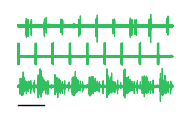

In [226]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 7.5+pdn[start_index:end_index]/0.4, c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 6.25+lpn[start_index:end_index]/250, c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn[start_index:end_index]/8, c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)

    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)

    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

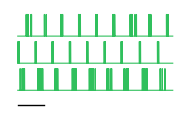

In [229]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3))
    ax.plot(t[start_index:end_index], 7.5+pdn_spikes[start_index:end_index], c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 6.25+lpn_spikes[start_index:end_index], c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn_spikes[start_index:end_index], c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)

## Extract summary stats

In [242]:
datafile = "../../../results/experimental_data/supplementary_traces/845_078_0036.abf"
abf = pyabf.ABF(datafile)

In [243]:
from stg_energy.experimental_data.read_data import reader, ABF_reader_078

r = ABF_reader_078(datafile)
r.read_preparation('xxx', subtract_PD=True)

10000.0


In [244]:
from stg_energy.experimental_data.summ_stats import PrinzExperimStats
s = PrinzExperimStats(include_pyloric_ness=True, include_plateaus=True)

In [245]:
summ_stats_experiment = s.calc(reader=r)[:-1]
for i in summ_stats_experiment:
    print(i)

409.6300546448087
87.02098092643031
57.3382513661207
98.99535519125696
99.40934065934042
41.857692307691515
186.1967032967029
285.23489010988936
0.2124379789512428
0.1399756944490776
0.24167014619348695
0.2426807787469074
0.10218413378868509
0.454548442394332
0.6963231503050168
2.5
2.5
2.5


In [246]:
# np.save('../../../results/experimental_data/xo_23deg_078.npy', summ_stats_experiment)

### Posterior sample

In [15]:
time_vec = np.arange(0, 11000, 0.025)

In [16]:
trace_posterior = simulate(theta.loc[0], seed=int(seeds[0]))

NameError: name 'theta' is not defined

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(2.0,1.2))
viz.vis_sample_plain(
    voltage_trace=trace_posterior,
    t=time_vec,
    axV=ax,
    time_len=int(time_len),
    offset=45000,
    col="k",
    scale_bar=False,
    scale_bar_voltage=False,
    print_label=False,
)
plt.savefig(PANEL_B, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

### Simulate the 2804 circuit configurations at 27 degree

In [17]:
def my_simulator(params_with_seeds):
    p1 = create_prior(
        customization={
            "Q10_gbar_mem": [True, True, True, True, True, True, True, True],
            "Q10_gbar_syn": [True, True],
            "Q10_tau_m": [False],
            "Q10_tau_h": [False],
            "Q10_tau_CaBuff": [False],
            "Q10_tau_syn": [False, False],
        }
    )
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=299,
        noise_std=0.001,
        track_energy=True,
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [18]:
q10_prior = create_prior(
    customization={
        "Q10_gbar_mem": [True, True, True, True, True, True, True, True],
        "Q10_gbar_syn": [True, True],
        "Q10_tau_m": [False],
        "Q10_tau_h": [False],
        "Q10_tau_CaBuff": [False],
        "Q10_tau_syn": [False, False],
    }
)
prior_parameter_sets_pd = q10_prior.sample((2804,))

In [20]:
global_seed = 0
np.random.seed(global_seed)  # Seeding the seeds for the simulator.
torch.manual_seed(global_seed)  # Seeding the prior.
seeds = np.random.randint(0, 10000, (2804, 1))

posterior_parameter_sets_pd = theta_11_11_close
posterior_parameter_sets_pd = posterior_parameter_sets_pd
posterior_data_np = posterior_parameter_sets_pd.to_numpy()

params_with_q10s = prior_parameter_sets_pd.to_numpy()
params_with_q10s[:, :31] = posterior_data_np

params_with_seeds = np.concatenate((params_with_q10s, seeds), axis=1)

In [21]:
# with Pool(12) as pool:
#     start_time = time.time()
#     data = pool.map(my_simulator, params_with_seeds)
#     print("Simulation time", time.time() - start_time)

In [22]:
# sim_outs = pd.concat(data)
# sim_outs_np = sim_outs.to_numpy()
# not_nan = np.invert(np.any(np.isnan(sim_outs_np), axis=1))
# print("number of good sims:  ", np.sum(not_nan))

In [23]:
# general_path = "/home/michael/Documents/STG_energy/results/"
# path_to_data = "simulation_data_Tube_MLslurm_cluster/simulate_11deg_R3_predictives_at_27deg_notau_only_close_016/data/"
# filename = f"sim_{global_seed}"
# sim_outs.to_pickle(
#     general_path + path_to_data + "simulation_outputs/" + filename + ".pkl"
# )
# prior_parameter_sets_pd.to_pickle(
#     general_path + path_to_data + "circuit_parameters/" + filename + ".pkl"
# )
# np.save(general_path + path_to_data + "seeds/" + filename, seeds)

### Load the 2804 circuit configurations at 27 degree

In [25]:
general_path = "/home/michael/Documents/STG_energy/results/"
path_to_data = "simulation_data_Tube_MLslurm_cluster/simulate_11deg_R3_predictives_at_27deg_notau_only_close_016/data/"
filename = "sim_0"

seeds_11_27_robust = np.load(general_path + path_to_data + "seeds/" + filename + ".npy")
theta_11_27_robust = pd.read_pickle(general_path + path_to_data + "circuit_parameters/" + filename + ".pkl")
x_11_27 = pd.read_pickle(general_path + path_to_data + "simulation_outputs/" + filename + ".pkl")

x_11_27_columns = x_11_27.columns

x_11_27_np = x_11_27.to_numpy()
condition = np.invert(np.any(np.isnan(x_11_27_np), axis=1))
x_11_27_robust_np = x_11_11_close[condition]

x_11_27_robust = pd.DataFrame(x_11_27_robust_np, columns=x_11_27_columns)

In [27]:
all_total_energies_11 = x_11_11_close['energies'].to_numpy()
all_total_energies_rejection = x_11_27_robust['energies'].to_numpy()

In [28]:
all_total_energies_11.shape

(2804, 3)

In [29]:
all_total_energies_rejection.shape

(476, 3)

In [30]:
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1) / 10 / 1000 # per second, micro-Joule
summed_energies_total_27_rejection = np.sum(np.asarray(all_total_energies_rejection), axis=1) / 10 / 1000

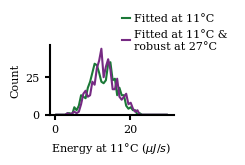

In [31]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

    hist_vals_11 = ax.hist(summed_energies_total_11[:476], range=(0, 30), bins=50, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27_rejection[:476], range=(0, 30), bins=50, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#762a83')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_ylim([0, 52])

    plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11°C & \nrobust at 27°C'), bbox_to_anchor=(0.5, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

#     plt.savefig(PANEL_C, facecolor='None', transparent=True)

### Scatterplot

In [ ]:
e_11 = np.sum(x_27_11_close['energies'].to_numpy(), axis=1) / 10 / 1000
e_27 = np.sum(x_27_27_close['energies'].to_numpy(), axis=1) / 10 / 1000

In [ ]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.2))
    ax.scatter(e_11[500:800], e_27[500:800], s=3, c='k')
    ax.plot([4, 24], [4, 24], c='gray', alpha=0.5)
    ax.set_xlabel("E at 11 °C ($\mu$J/s)")
    ax.set_ylabel("E at 27 °C ($\mu$J/s)")
    plt.savefig(PANEL_F, facecolor='None', transparent=True)

### Grand finale

In [ ]:
all_total_energies_27 = x_27_11_close['energies'].to_numpy()
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1) / 10 / 1000

In [ ]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

    hist_vals_11 = ax.hist(summed_energies_total_11[:900], range=(0, 30), bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27[:900], range=(0, 30), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#c51b7d')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, 52])
    ax.set_yticks([])

    plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11 & 27°C'), bbox_to_anchor=(0.6, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

    plt.savefig(PANEL_D1, facecolor='None', transparent=True)

# Assemble figure

In [122]:
color_mixture1 = 0.33 * np.asarray(list(col['CONSISTENT1'])) + 0.67 * np.asarray(
    list(col['CONSISTENT2']))
color_mixture2 = 0.67 * np.asarray(list(col['CONSISTENT1'])) + 0.33 * np.asarray(
    list(col['CONSISTENT2']))

In [162]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [164]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

startx1 = 492
startx2 = 594
starty1 = 204
starty2 = 307

endx1 = 642
endx2 = 673
endy1 = 159
endy2 = 191

deltax1 =  endx1-startx1
deltax2 =  endx2-startx2
deltay1 =  endy1-starty1
deltay2 =  endy2-starty2

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "3.2cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("a", -2*factor_svg, 2.3*factor_svg-dshift, **kwargs_text),
        Text("PD", -1.*factor_svg, 6.8*factor_svg, **kwargs_text8pt),
        Text("LP", -1.*factor_svg, 11.3*factor_svg, **kwargs_text8pt),
        Text("PY", -1.*factor_svg, 15.8*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 0*factor_svg+dshift),

    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 1.8*factor_svg-dshift, **kwargs_text),
    ).move(33.0*factor_svg, 0.5*factor_svg+dshift),
           
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("c", -0*factor_svg, 1.1*factor_svg-dshift, **kwargs_text),
    ).move(67*factor_svg, 1.2*factor_svg+dshift),
           
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("d", -10.5*factor_svg, 1.9*factor_svg-dshift, **kwargs_text),
    ).move(99.5*factor_svg, 0.4*factor_svg+dshift),

    Panel(
          SVG(PANEL_E).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("e", -15.5*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
        Text("PD", -12.*factor_svg, 7.2*factor_svg, **kwargs_text8pt),
        Text("LP", -12.*factor_svg, 11.6*factor_svg, **kwargs_text8pt),
        Text("PY", -12.*factor_svg, 15.8*factor_svg, **kwargs_text8pt),
    ).move(15.5*factor_svg, 25.5*factor_svg+dshift),

)

!mkdir -p fig
f.save("../fig/fig5.svg")
svg('../fig/fig5.svg')